<a href="https://colab.research.google.com/github/sauravsingla/General/blob/master/Predictive_Maintenance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandasql

  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [ ]:
# libraries
import pandas as pd
import numpy as np

import matplotlib
import seaborn
import matplotlib.dates as md
from matplotlib import pyplot as plt

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope

from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM

import pandasql as ps

In [ ]:
# some function for later
# return Series of distance between each point and his distance with the closest centroid
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

# train markov model to get transition matrix
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(anomalyElement(sequence, real_threshold, transition_matrix))
    return df_anomaly

In [ ]:
# Importing the data
df = pd.read_csv("2019-01-tmp.csv")

In [ ]:
# Searching for Missings,type of data and also known the shape of data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44338 entries, 0 to 44337
Columns: 134 entries, TimeStamp to wtc_MainBTmp_stddev
dtypes: float64(76), int64(57), object(1)
memory usage: 45.3+ MB
None


In [ ]:
# Looking columns names
df.columns

Index(['TimeStamp', 'StationId', 'wtc_A1ExtTmp_min', 'wtc_A1ExtTmp_max',
       'wtc_A1ExtTmp_mean', 'wtc_A1IntTmp_min', 'wtc_A1IntTmp_max',
       'wtc_A1IntTmp_mean', 'wtc_A2IntTmp_min', 'wtc_A2IntTmp_max',
       ...
       'wtc_ReacVTmp_mean', 'wtc_ReacVTmp_stddev', 'wtc_ReacWTmp_min',
       'wtc_ReacWTmp_max', 'wtc_ReacWTmp_mean', 'wtc_ReacWTmp_stddev',
       'wtc_MainBTmp_min', 'wtc_MainBTmp_max', 'wtc_MainBTmp_mean',
       'wtc_MainBTmp_stddev'],
      dtype='object', length=134)

In [ ]:
# data type and their frequency
print("Data types and their frequency\n{}".format(df.dtypes.value_counts()))

Data types and their frequency
float64    76
int64      57
object      1
dtype: int64


In [ ]:
# check the timestamp format and frequence 
print(df['TimeStamp'].head(5))

0    01-01-2019 00:00
1    01-01-2019 00:00
2    01-01-2019 00:00
3    01-01-2019 00:00
4    01-01-2019 00:00
Name: TimeStamp, dtype: object


In [ ]:
# unique StationID values 
print(df['StationId'].unique())

[2301722 2301723 2301724 2301725 2301726 2301727 2301728 2301729 2301730
 2301731 2301732 2301733 2301734 2301735 2301736 2301737 2301738 2301739
 2301740 2301741 2301742 2301743 2301744 2301745 2301746 2301747 2301748
 2301749 2301750 2301751 2301752 2301753 2301754 2301755 2301756 2301757
 2301758 2301759 2301760 2301761 2301762 2301763 2301764 2301765]


In [ ]:
df.head(5)

,TimeStamp,StationId,wtc_A1ExtTmp_min,wtc_A1ExtTmp_max,wtc_A1ExtTmp_mean,wtc_A1IntTmp_min,wtc_A1IntTmp_max,wtc_A1IntTmp_mean,wtc_A2IntTmp_min,wtc_A2IntTmp_max,wtc_A2IntTmp_mean,wtc_A3LefTmp_min,wtc_A3LefTmp_max,wtc_A3LefTmp_mean,wtc_A3RigTmp_min,wtc_A3RigTmp_max,wtc_A3RigTmp_mean,wtc_A9IntTmp_min,wtc_A9IntTmp_max,wtc_A9IntTmp_mean,wtc_AmbieTmp_min,wtc_AmbieTmp_max,wtc_AmbieTmp_mean,wtc_BrkTmpGn_min,wtc_BrkTmpGn_max,wtc_BrkTmpGn_mean,wtc_Gen1U1Tm_min,wtc_Gen1U1Tm_max,wtc_Gen1U1Tm_mean,wtc_Gen1V1Tm_min,wtc_Gen1V1Tm_max,wtc_Gen1V1Tm_mean,wtc_Gen1W1Tm_min,wtc_Gen1W1Tm_max,wtc_Gen1W1Tm_mean,wtc_GenBeGTm_min,wtc_GenBeGTm_max,wtc_GenBeGTm_mean,wtc_GenBeRTm_min,wtc_GenBeRTm_max,...,wtc_IO2IntTm_stddev,wtc_IO3IntTm_stddev,wtc_NacelTmp_stddev,wtc_NMMBrdTm_stddev,wtc_ConvWTmp_min,wtc_ConvWTmp_max,wtc_ConvWTmp_mean,wtc_ConvWTmp_stddev,wtc_HydOilTm_min,wtc_HydOilTm_max,wtc_HydOilTm_mean,wtc_HydOilTm_stddev,wtc_GFilB1Tm_min,wtc_GFilB1Tm_max,wtc_GFilB1Tm_mean,wtc_GFilB1Tm_stddev,wtc_GFilB2Tm_min,wtc_GFilB2Tm_max,wtc_GFilB2Tm_mean,wtc_GFilB2Tm_stddev,wtc_GFilB3Tm_min,wtc_GFilB3Tm_max,wtc_GFilB3Tm_mean,wtc_GFilB3Tm_stddev,wtc_ReacUTmp_min,wtc_ReacUTmp_max,wtc_ReacUTmp_mean,wtc_ReacUTmp_stddev,wtc_ReacVTmp_min,wtc_ReacVTmp_max,wtc_ReacVTmp_mean,wtc_ReacVTmp_stddev,wtc_ReacWTmp_min,wtc_ReacWTmp_max,wtc_ReacWTmp_mean,wtc_ReacWTmp_stddev,wtc_MainBTmp_min,wtc_MainBTmp_max,wtc_MainBTmp_mean,wtc_MainBTmp_stddev
0,01-01-2019 00:00,2301722,18,20,18.672750,24,30,27.349171,30,30,30.000000,28,28,28.000000,27,27,27.000000,23,23,23.0,9,10,9.401716,31,31,31.000000,98,105,102.066498,99,105,101.866096,99,104,101.473396,61,61,61.000000,49,50,...,0.188090,0.061077,0.000000,2.208530,46.799999,49.400002,48.000420,0.560879,40,40,40.000000,0.000000,23,24,23.89580,0.305520,22,23,22.169451,0.375149,22,23,22.416500,0.492979,69,72,70.409157,0.675808,55,56,55.493172,0.499953,58,60,59.061481,0.603824,22,22,22.000000,0.000000
1,01-01-2019 00:00,2301723,23,23,23.000000,26,27,26.269100,24,24,24.000000,27,27,27.000000,29,29,29.000000,29,29,29.0,10,10,10.000000,36,37,36.259380,101,107,103.962997,100,106,103.430397,101,106,103.748100,68,68,68.000000,56,57,...,0.189707,0.137225,0.484525,0.111389,47.400002,49.000000,48.075081,0.318738,39,41,39.865768,0.652673,27,28,27.32902,0.469856,25,26,25.197100,0.397808,25,26,25.993750,0.078810,60,60,60.000000,0.000000,63,64,63.684071,0.464886,64,64,64.000000,0.000000,25,26,25.803471,0.397376
2,01-01-2019 00:00,2301724,18,19,18.201200,27,33,30.337879,17,20,17.914351,27,28,27.997280,27,28,27.620850,25,25,25.0,9,10,9.183984,37,37,37.000000,101,108,104.246597,104,109,106.633499,103,109,105.900803,67,68,67.998337,42,42,...,0.212262,0.769575,0.000000,2.907389,36.099998,50.299999,46.523060,4.495940,38,40,39.111599,0.330321,23,25,23.90427,0.449001,21,22,21.804251,0.396777,21,21,21.000000,0.000000,69,71,70.090393,0.376626,56,57,56.505051,0.499974,57,58,57.247532,0.431579,25,26,25.555731,0.496884
3,01-01-2019 00:00,2301725,19,20,19.052170,19,19,19.000000,23,24,23.880180,27,28,27.595369,26,27,26.778481,23,23,23.0,9,9,9.000000,32,32,32.000000,101,108,104.529800,101,110,104.972199,100,110,104.999497,68,68,68.000000,47,48,...,0.192210,0.262542,0.000000,0.058328,45.599998,47.099998,46.511311,0.375260,39,40,39.430870,0.495198,22,23,22.30298,0.459548,20,21,20.141500,0.348537,20,21,20.977720,0.147603,70,71,70.998657,0.036490,70,72,70.764603,0.448092,67,68,67.751617,0.432075,25,25,25.000000,0.000000
4,01-01-2019 00:00,2301726,17,19,17.629351,25,35,30.961571,17,17,17.000000,25,26,25.834200,27,27,27.000000,22,22,22.0,9,10,9.722900,29,30,29.927919,100,106,103.263603,100,107,103.267502,100,106,102.829697,69,69,69.000000,37,38,...,0.060209,0.077237,0.000000,4.602130,44.500000,45.400002,44.822029,0.180198,39,41,39.622299,0.596917,24,25,24.81510,0.388216,21,22,21.621099,0.485113,22,24,22.781269,0.417439,65,67,66.073303,0.415043,63,65,64.026733,0.263664,63,64,63.708771,0.454331,20,20,20.000000,0.000000


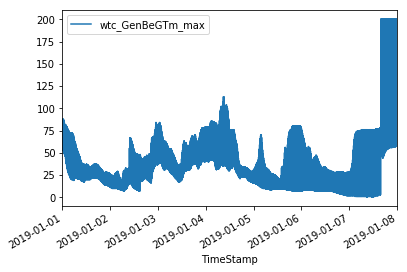

In [ ]:
# change the type of timestamp column for plotting
# df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], unit='s').dt.strftime('%Y-%m-%d %H:%M')
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
# plot the data
df.plot(x='TimeStamp', y='wtc_GenBeGTm_max')

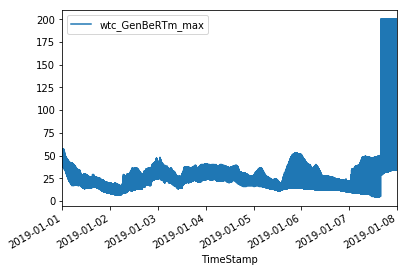

In [ ]:
# plot the data
df.plot(x='TimeStamp', y= 'wtc_GenBeRTm_max')

In [ ]:
# selecting subset of columns from the main dataframe
new_df = df[['TimeStamp','StationId','wtc_GenBeGTm_min', 'wtc_GenBeGTm_max', 'wtc_GenBeGTm_mean', 'wtc_GenBeRTm_min', 'wtc_GenBeRTm_max', 'wtc_GenBeRTm_mean']]

In [ ]:
# top 5 rows
new_df.head(5)

,TimeStamp,StationId,wtc_GenBeGTm_min,wtc_GenBeGTm_max,wtc_GenBeGTm_mean,wtc_GenBeRTm_min,wtc_GenBeRTm_max,wtc_GenBeRTm_mean
0,2019-01-01,2301722,61,61,61.000000,49,50,49.626171
1,2019-01-01,2301723,68,68,68.000000,56,57,56.345299
2,2019-01-01,2301724,67,68,67.998337,42,42,42.000000
3,2019-01-01,2301725,68,68,68.000000,47,48,47.934872
4,2019-01-01,2301726,69,69,69.000000,37,38,37.792030


44338
44338


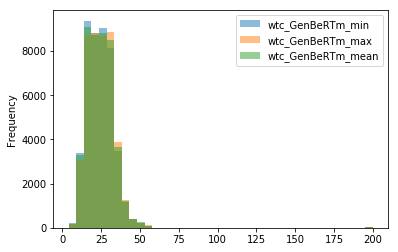

In [ ]:
# distribution
df_columns = ['wtc_GenBeRTm_min', 'wtc_GenBeRTm_max', 'wtc_GenBeRTm_mean']

print(df.shape[0])
df.dropna(subset=df_columns,inplace=True)
print(df.shape[0])

df[df_columns].plot.hist(alpha=0.5,bins=40);

44338
44338


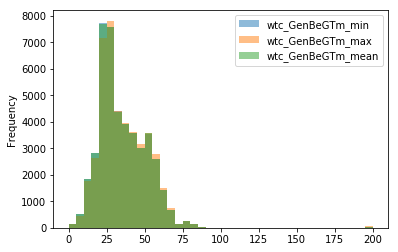

In [ ]:
# distribution
df_columns = ['wtc_GenBeGTm_min', 'wtc_GenBeGTm_max', 'wtc_GenBeGTm_mean']

print(df.shape[0])
df.dropna(subset=df_columns,inplace=True)
print(df.shape[0])

df[df_columns].plot.hist(alpha=0.5,bins=40);

In [ ]:
# distribution of the sub variables of the description attribute
new_df.groupby("StationId").describe() 

wtc_GenBeGTm_min             ... wtc_GenBeRTm_mean            
                     count       mean  ...               75%         max
StationId                              ...                              
2301722             1009.0  32.547076  ...         32.658352   49.889801
2301723             1009.0  37.937562  ...         33.000000   57.000000
2301724             1009.0  36.337958  ...         30.000000   47.986950
2301725             1009.0  33.692765  ...         32.000000   47.934872
2301726             1009.0  33.891972  ...         29.498920   38.000000
2301727             1009.0  41.153617  ...         35.000000  200.000000
2301728             1009.0  35.036670  ...         28.000000   43.000000
2301729             1009.0  33.376611  ...         25.993870   38.000000
2301730             1009.0  37.590684  ...         34.001320   54.998329
2301731             1009.0  33.936571  ...         28.000000   39.000000
2301732             1009.0  31.756194  ...         27.000000   40.000000
2301733             1009.0  41.130823  ...         28.996281   40.000000
2301734             1009.0  37.717542  ...         27.714001   51.518951
2301735             1009.0  34.519326  ...         31.275000   44.899170
2301736             1009.0  36.579782  ...         29.134081   38.000000
2301737             1009.0  34.584737  ...         28.083370   53.000000
2301738             1009.0  33.162537  ...         30.842051   43.000000
2301739              980.0  37.341837  ...         32.000358   44.706249
2301740             1009.0  35.017839  ...         29.826469   41.017681
2301741             1009.0  33.381566  ...         29.527920   37.000000
2301742             1009.0  34.523290  ...         28.000000   40.000000
2301743             1009.0  36.736373  ...         30.000000   50.001678
2301744              980.0  32.770408  ...         31.923072   40.000000
2301745             1009.0  35.507433  ...         31.000000   42.725769
2301746             1009.0  34.247770  ...         28.000000   51.000000
2301747             1009.0  35.525273  ...         29.000000   41.000000
2301748             1009.0  32.948464  ...         28.199800   39.000000
2301749             1009.0  36.890981  ...         36.761349   51.996670
2301750             1009.0  29.933598  ...         25.000000   39.918301
2301751             1009.0  32.374628  ...         31.962450   50.994732
2301752             1009.0  31.942517  ...         29.000000   39.000000
2301753             1009.0  32.584737  ...         26.885050   39.314999
2301754             1009.0  39.116947  ...         25.000000   42.000000
2301755             1009.0  35.093162  ...         32.000000   40.000000
2301756             1009.0  34.416254  ...         35.000000   49.000000
2301757             1009.0  35.813677  ...         33.295719   50.000000
2301758             1009.0  31.729435  ...         34.000000   45.000000
2301759             1009.0  37.259663  ...         29.000000   46.111622
2301760             1009.0  31.265610  ...         28.000000   44.000000
2301761             1009.0  33.519326  ...         30.000000   50.966351
2301762             1009.0  33.555996  ...         30.872070   41.018620
2301763             1009.0  34.432111  ...         32.000000   43.000000
2301764             1009.0  34.229931  ...         35.417870   57.000000
2301765             1009.0  35.430129  ...         27.061399   40.000000

[44 rows x 48 columns]

Cluster based anomaly detection (K-mean)

In [ ]:
# Take useful feature and standardize them
data = new_df[['wtc_GenBeGTm_min', 'wtc_GenBeGTm_max', 'wtc_GenBeGTm_mean', 'wtc_GenBeRTm_min', 'wtc_GenBeRTm_max', 'wtc_GenBeRTm_mean']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 importants features
pca = PCA(n_components=2)
data = pca.fit_transform(data)
# standardize these 2 new features
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)

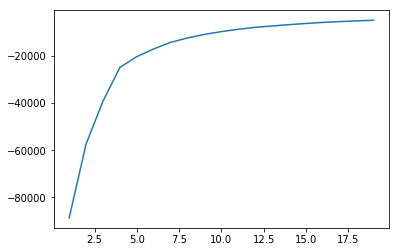

In [ ]:
# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [ ]:
# Not clear for me, I choose 15 centroids arbitrarily and add these data to the central dataframe
new_df['cluster'] = kmeans[14].predict(data)
new_df['principal_feature1'] = data[0]
new_df['principal_feature2'] = data[1]
new_df['cluster'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

3     7390
0     6074
11    3861
7     3702
5     3683
2     3655
1     3637
10    3325
13    2288
12    2245
6     1704
9     1605
14     579
8      540
4       50
Name: cluster, dtype: int64

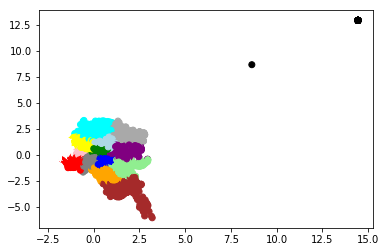

In [ ]:
#plot the different clusters with the 2 main features
# 
fig, ax = plt.subplots()
colors = {0:'red', 1:'blue', 2:'green', 3:'pink', 4:'black', 5:'orange', 6:'cyan', 7:'yellow', 8:'brown', 9:'purple', 10:'white', 11: 'grey', 12:'lightblue', 13:'lightgreen', 14: 'darkgrey' }
ax.scatter(new_df['principal_feature1'], new_df['principal_feature2'], c=new_df["cluster"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
# get the distance between each point and its nearest centroid. The biggest distances are considered as anomaly
outliers_fraction = 0.01
distance = getDistanceByPoint(data, kmeans[14])
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
# anomaly21 contain the anomaly result of method 2.1 Cluster (0:normal, 1:anomaly) 
new_df['anomaly21'] = (distance >= threshold).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


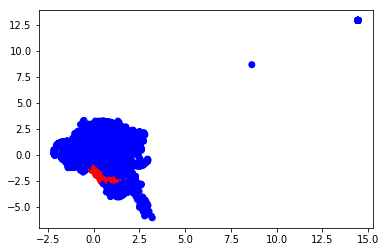

In [ ]:
# visualisation of anomaly with cluster view
fig, ax = plt.subplots()
colors = {0:'blue', 1:'red'}
ax.scatter(new_df['principal_feature1'], new_df['principal_feature2'], c=new_df["anomaly21"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
# top rows
new_df[new_df['anomaly21'] == 1].head(2)

,TimeStamp,StationId,wtc_GenBeGTm_min,wtc_GenBeGTm_max,wtc_GenBeGTm_mean,wtc_GenBeRTm_min,wtc_GenBeRTm_max,wtc_GenBeRTm_mean,cluster,principal_feature1,principal_feature2,anomaly21
912,2019-01-01 03:20:00,2301754,57,60,58.411968,26,26,26.0,5,0.838021,-2.420009,1
963,2019-01-01 03:30:00,2301754,54,57,55.149971,26,26,26.0,5,0.737074,-2.064674,1


In [ ]:
# Wind Turbines with no fault are 2301750, 2301745, 2301762, 2301728, 2301752, 2301741
q1 = "SELECT StationId FROM new_df WHERE anomaly21 = 1 AND StationId IN (2301750, 2301745, 2301762, 2301728, 2301752, 2301741)"
print(ps.sqldf(q1, locals()))

   StationId
0    2301741


In [ ]:
# grouping
new_df.groupby('anomaly21')['StationId'].count()

anomaly21
0    43895
1      443
Name: StationId, dtype: int64

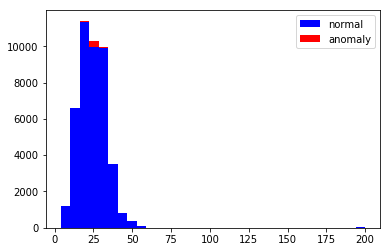

In [ ]:
# visualisation of anomaly with temperature repartition 
a = new_df.loc[new_df['anomaly21'] == 0, 'wtc_GenBeRTm_max']
b = new_df.loc[new_df['anomaly21'] == 1, 'wtc_GenBeRTm_max']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

One Class SVM

In [ ]:
# Take useful feature and standardize them 
data = new_df[['wtc_GenBeGTm_min', 'wtc_GenBeGTm_max', 'wtc_GenBeGTm_mean', 'wtc_GenBeRTm_min', 'wtc_GenBeRTm_max', 'wtc_GenBeRTm_mean']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
# train one class SVM 
model =  OneClassSVM(nu=0.95 * outliers_fraction) #nu=0.95 * outliers_fraction  + 0.05
data = pd.DataFrame(np_scaled)
model.fit(data)
# add the data to the main  
new_df['anomaly26'] = pd.Series(model.predict(data))
new_df['anomaly26'] = new_df['anomaly26'].map( {1: 0, -1: 1} )
print(new_df['anomaly26'].value_counts())

0    43916
1      422
Name: anomaly26, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Wind Turbines with no fault are 2301750, 2301745, 2301762, 2301728, 2301752, 2301741
q1 = "SELECT StationId FROM new_df WHERE anomaly26 = 1 AND StationId IN (2301750, 2301745, 2301762, 2301728, 2301752, 2301741)"
print(ps.sqldf(q1, locals()))

   StationId
0    2301752
1    2301741
2    2301741
3    2301741
4    2301752


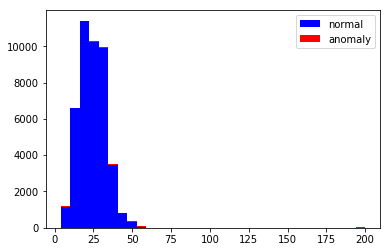

In [ ]:
# visualisation of anomaly with temperature repartition 
a = new_df.loc[new_df['anomaly26'] == 0, 'wtc_GenBeRTm_max']
b = new_df.loc[new_df['anomaly26'] == 1, 'wtc_GenBeRTm_max']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

Isolation Forest

In [ ]:
# Take useful feature and standardize them 
data = new_df[['wtc_GenBeGTm_min', 'wtc_GenBeGTm_max', 'wtc_GenBeGTm_mean', 'wtc_GenBeRTm_min', 'wtc_GenBeRTm_max', 'wtc_GenBeRTm_mean']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# train isolation forest 
model =  IsolationForest(contamination = outliers_fraction)
model.fit(data)
# add the data to the main  
new_df['anomaly25'] = pd.Series(model.predict(data))
new_df['anomaly25'] = new_df['anomaly25'].map( {1: 0, -1: 1} )
print(new_df['anomaly25'].value_counts())

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


0    43898
1      440
Name: anomaly25, dtype: int64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
# Wind Turbines with no fault are 2301750, 2301745, 2301762, 2301728, 2301752, 2301741
q1 = "SELECT StationId FROM new_df WHERE anomaly25 = 1 AND StationId IN (2301750, 2301745, 2301762, 2301728, 2301752, 2301741)"
print(ps.sqldf(q1, locals()))

Empty DataFrame
Columns: [StationId]
Index: []


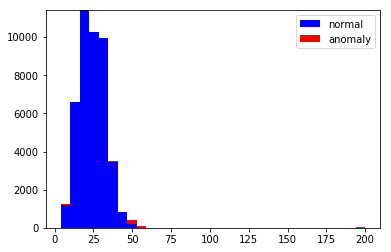

In [ ]:
# visualisation of anomaly with temperature repartition 
a = new_df.loc[new_df['anomaly25'] == 0, 'wtc_GenBeRTm_max']
b = new_df.loc[new_df['anomaly25'] == 1, 'wtc_GenBeRTm_max']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label = ['normal', 'anomaly'])
plt.legend()
plt.show()

Categories + Gaussian

In [ ]:
# change the type of timestamp column for plotting
new_df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
# the hours and if it's night or day (7:00-22:00)
new_df['hours'] = df['TimeStamp'].dt.hour
new_df['daylight'] = ((new_df['hours'] >= 7) & (new_df['hours'] <= 22)).astype(int)
# the day of the week (Monday=0, Sunday=6) and if it's a week end day or week day.
new_df['DayOfTheWeek'] = new_df['TimeStamp'].dt.dayofweek
new_df['WeekDay'] = (new_df['DayOfTheWeek'] < 5).astype(int)
# An estimation of anomly population of the dataset (necessary for several algorithm)
outliers_fraction = 0.01
# time with int to plot easily
new_df['time_epoch'] = (new_df['TimeStamp'].astype(np.int64)/100000000000).astype(np.int64)
# creation of 4 distinct categories that seem useful (week end/day week & night/day)
new_df['categories'] = new_df['WeekDay']*2 + new_df['daylight']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

In [ ]:
# creation of 4 differents data set based on categories defined before
df_class0 = new_df.loc[new_df['categories'] == 0, 'wtc_GenBeRTm_max']
df_class1 = new_df.loc[new_df['categories'] == 1, 'wtc_GenBeRTm_max']
df_class2 = new_df.loc[new_df['categories'] == 2, 'wtc_GenBeRTm_max']
df_class3 = new_df.loc[new_df['categories'] == 3, 'wtc_GenBeRTm_max']

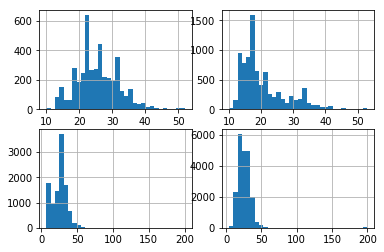

In [ ]:
# plot the temperature repartition by categories
fig, axs = plt.subplots(2,2)
df_class0.hist(ax=axs[0,0],bins=32)
df_class1.hist(ax=axs[0,1],bins=32)
df_class2.hist(ax=axs[1,0],bins=32)
df_class3.hist(ax=axs[1,1],bins=32)

In [ ]:
# apply ellipticEnvelope(gaussian distribution) at each categories
envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class0.values.reshape(-1,1)
envelope.fit(X_train)
df_class0 = pd.DataFrame(df_class0)
df_class0['deviation'] = envelope.decision_function(X_train)
df_class0['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class1.values.reshape(-1,1)
envelope.fit(X_train)
df_class1 = pd.DataFrame(df_class1)
df_class1['deviation'] = envelope.decision_function(X_train)
df_class1['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class2.values.reshape(-1,1)
envelope.fit(X_train)
df_class2 = pd.DataFrame(df_class2)
df_class2['deviation'] = envelope.decision_function(X_train)
df_class2['anomaly'] = envelope.predict(X_train)

envelope =  EllipticEnvelope(contamination = outliers_fraction) 
X_train = df_class3.values.reshape(-1,1)
envelope.fit(X_train)
df_class3 = pd.DataFrame(df_class3)
df_class3['deviation'] = envelope.decision_function(X_train)
df_class3['anomaly'] = envelope.predict(X_train)

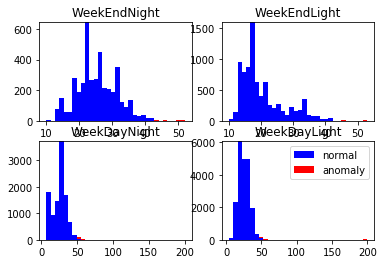

In [ ]:
# plot the temperature repartition by categories with anomalies
a0 = df_class0.loc[df_class0['anomaly'] == 1, 'wtc_GenBeRTm_max']
b0 = df_class0.loc[df_class0['anomaly'] == -1, 'wtc_GenBeRTm_max']

a1 = df_class1.loc[df_class1['anomaly'] == 1, 'wtc_GenBeRTm_max']
b1 = df_class1.loc[df_class1['anomaly'] == -1, 'wtc_GenBeRTm_max']

a2 = df_class2.loc[df_class2['anomaly'] == 1, 'wtc_GenBeRTm_max']
b2 = df_class2.loc[df_class2['anomaly'] == -1, 'wtc_GenBeRTm_max']

a3 = df_class3.loc[df_class3['anomaly'] == 1, 'wtc_GenBeRTm_max']
b3 = df_class3.loc[df_class3['anomaly'] == -1, 'wtc_GenBeRTm_max']

fig, axs = plt.subplots(2,2)
axs[0,0].hist([a0,b0], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,1].hist([a1,b1], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,0].hist([a2,b2], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[1,1].hist([a3,b3], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
axs[0,0].set_title("WeekEndNight")
axs[0,1].set_title("WeekEndLight")
axs[1,0].set_title("WeekDayNight")
axs[1,1].set_title("WeekDayLight")
plt.legend()
plt.show()

In [ ]:
# add the data to the main 
df_class = pd.concat([df_class0, df_class1, df_class2, df_class3])
new_df['anomaly22'] = df_class['anomaly']
new_df['anomaly22'] = np.array(new_df['anomaly22'] == -1).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Wind Turbines with no fault are 2301750, 2301745, 2301762, 2301728, 2301752, 2301741
q1 = "SELECT StationId FROM new_df WHERE anomaly22 = 1 AND StationId IN (2301750, 2301745, 2301762, 2301728, 2301752, 2301741)"
print(ps.sqldf(q1, locals()))

Empty DataFrame
Columns: [StationId]
Index: []


In [ ]:
# grouping
new_df.groupby('anomaly22')['StationId'].count()

anomaly22
0    43946
1      392
Name: StationId, dtype: int64

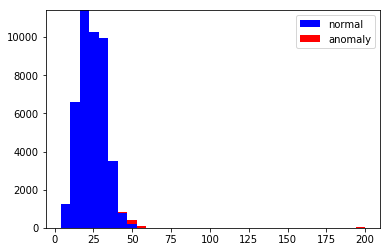

In [ ]:
# visualisation of anomaly with temperature repartition 
a = new_df.loc[new_df['anomaly22'] == 0, 'wtc_GenBeRTm_max']
b = new_df.loc[new_df['anomaly22'] == 1, 'wtc_GenBeRTm_max']

fig, axs = plt.subplots()
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'], label=['normal', 'anomaly'])
plt.legend()
plt.show()

In [ ]:
new_df[(new_df['anomaly21'] == 1) | (new_df['anomaly22'] == 1) | (new_df['anomaly25'] == 1) | (new_df['anomaly26'] == 1)].head(5)

,TimeStamp,StationId,wtc_GenBeGTm_min,wtc_GenBeGTm_max,wtc_GenBeGTm_mean,wtc_GenBeRTm_min,wtc_GenBeRTm_max,wtc_GenBeRTm_mean,cluster,principal_feature1,principal_feature2,anomaly21,anomaly26,anomaly25,hours,daylight,DayOfTheWeek,WeekDay,time_epoch,categories,anomaly22
1,2019-01-01,2301723,68,68,68.000000,56,57,56.345299,14,2.719916,2.020856,0,1,1,0,0,1,1,15463008,2,1
3,2019-01-01,2301725,68,68,68.000000,47,48,47.934872,9,2.265890,0.419806,0,0,1,0,0,1,1,15463008,2,0
5,2019-01-01,2301727,82,82,82.000000,52,52,52.000000,9,2.948326,-0.400671,0,1,1,0,0,1,1,15463008,2,1
8,2019-01-01,2301730,71,71,71.000000,54,55,54.998329,14,2.726084,1.351514,0,1,1,0,0,1,1,15463008,2,1
12,2019-01-01,2301734,72,73,72.506737,51,52,51.013149,9,2.603525,0.573419,0,0,1,0,0,1,1,15463008,2,1


In [ ]:
new_df[(new_df['anomaly21'] == 1)].to_csv('clustering.csv', encoding='utf-8', index=False)

In [ ]:
new_df[(new_df['anomaly22'] == 1)].to_csv('gaussian.csv', encoding='utf-8', index=False)

In [ ]:
new_df[(new_df['anomaly25'] == 1)].to_csv('isolation_forest.csv', encoding='utf-8', index=False)

In [ ]:
new_df[(new_df['anomaly26'] == 1)].to_csv('one_class_svm.csv', encoding='utf-8', index=False)

Isolation Forest & Gaussian did not shown classify Wind turbines 2301750, 2301745, 2301762, 2301728, 2301752, 2301741 unhealthy. On the other hand One Class SVM  classify 2 turbines out of list provided as unhealthy. Lastly, Kmeans clustering classify 1 turbine out of list provided as unhealthy